# Noise ceiling function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import scipy.spatial as sp
import scipy.optimize as so
import random


#%matplotlib inline

# Import datasets

In [2]:
y_res11 = pd.read_csv('y_res11.csv', header=None)
y_res12 = pd.read_csv('y_res12.csv', header=None)
y_res13 = pd.read_csv('y_res13.csv', header=None)
y_res21 = pd.read_csv('y_res21.csv', header=None)
y_res22 = pd.read_csv('y_res22.csv', header=None)
y_res23 = pd.read_csv('y_res23.csv', header=None)
y_res31 = pd.read_csv('y_res31.csv', header=None)
y_res32 = pd.read_csv('y_res32.csv', header=None)
y_res33 = pd.read_csv('y_res33.csv', header=None)

col_names=['x', 'y', 'z', 'depth']
location11=pd.read_csv('location11.csv',names=col_names)
location12=pd.read_csv('location12.csv',names=col_names)
location13=pd.read_csv('location13.csv',names=col_names)
location21=pd.read_csv('location21.csv',names=col_names)
location22=pd.read_csv('location22.csv',names=col_names)
location23=pd.read_csv('location23.csv',names=col_names)
location31=pd.read_csv('location31.csv',names=col_names)
location32=pd.read_csv('location32.csv',names=col_names)
location33=pd.read_csv('location33.csv',names=col_names)

# View y_res.csv

In [4]:
print(y_res31.shape)
y_res31.head()

(3488, 847)


,0,1,2,3,4,5,6,7,8,9,...,837,838,839,840,841,842,843,844,845,846
0,-1.4197,-8.5145,22.4740,7.5816,16.9690,-1.7700,5.7982,19.5650,12.5840,-9.8764,...,13.8270,5.1841,13.5110,-6.9979,0.94306,-11.49700,-11.0320,-1.9434,-9.6741,-2.1443
1,-16.9590,-31.4790,-23.9120,-9.6211,12.4460,-14.1790,-11.7510,16.4100,2.1783,-10.5200,...,13.5240,-11.9720,2.6456,43.6860,-6.30200,0.21438,3.5338,3.2956,-25.9160,7.6326
2,4.0481,2.5619,3.3671,10.7770,13.4050,-9.8239,-18.9150,-25.9100,-25.5560,-21.0850,...,15.6900,12.5320,-14.7590,-14.5530,9.76370,35.03700,-6.3936,3.2477,13.9820,6.6764
3,-7.3464,11.4970,-21.9240,-13.4260,4.3573,-7.3909,5.5279,16.4740,4.8506,3.0671,...,-5.1095,-8.1099,-14.0290,-47.4240,-9.50470,-2.73380,-12.6530,4.0468,14.4600,-12.6820
4,18.6390,23.1430,9.7232,9.0204,4.4300,-10.6500,15.3350,2.1113,-13.9750,8.1857,...,8.5187,7.8150,-34.6730,-11.5700,-9.88470,21.08700,-10.9880,-25.9270,8.4714,-11.4350


# View location.csv

In [5]:
print(location31.shape)
location31.head()

(847, 4)


,x,y,z,depth
0,-56.539,-68.870,-13.999,1.175300
1,-58.539,-68.844,-14.025,0.898590
2,-56.526,-67.045,-13.183,0.820110
3,-58.526,-67.019,-13.208,0.036471
4,-56.513,-65.219,-12.366,1.101400


# Define a function get correlation from any given y_res

In [3]:
def get_corr(Y_res):
    
    #obtaining the correlation between voxels
    corr=Y_res.corr(method ='pearson')
    corr_tril=np.tril(corr,k=-1)
    Corr=corr_tril[np.nonzero(corr_tril)]
    Corr=Corr.reshape(-1,1)
    #Corr=pd.DataFrame(Corr)
    return Corr

# Define a function get design matrix X from dataframe: location
### exp_model: $Corr=\beta_0+\beta_1*exp^{(-dist*\gamma)}+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$
### power_model: $Corr=\beta_0+\beta_1*\eta^{dist}+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$

In [3]:
def get_design_matrix(Location,model_type="both",gamma=0.2,eta=0.8):
    #Here model_type= "both"/"with interaction"/"without interaction"
    #If model_type= "both", then construct design matrices both with interaction and without interaction
    #If model_type="with interaction", then only construct design matrix with interaction
    #If model_type="without interaction", then only construct design matrix without interaction

    #Obtaining the distance between voxels
    dist_matrix=sp.distance_matrix(Location.iloc[:,0:2],Location.iloc[:,0:2])
    dist_tril=np.tril(dist_matrix,k=-1)
    rowid,colid=np.nonzero(dist_tril)
    dist=dist_tril[rowid,colid]
    dist=dist.reshape(-1,1)
    
    exp_dist=np.exp(-dist*gamma)
    power_dist=[eta**k for k in dist]

    #Obtaining the depth from the 1st voxel
    dep1=Location.depth[rowid]
    dep1=dep1.values
    dep1=dep1.reshape(-1,1)

    #obtaining depth from the 2ed voxel
    dep2=Location.depth[colid]
    dep2=dep2.values
    dep2=dep2.reshape(-1,1)

    dep1_2=dep1*dep2
    ones=np.ones(len(dist)).reshape(-1,1)

    #Creat the design matrix
    if model_type=="with interaction":
        #construct design matrix with interaction
        X_exp_inter=np.concatenate((ones,exp_dist,dep1,dep2,dep1_2),axis=1)
        names_exp_inter=['intercept','exp_dist','dep1','dep2','dep12']
        #X_exp_inter=pd.DataFrame(X_exp_inter,columns=names_exp_inter)
    
        X_power_inter=np.concatenate((ones,power_dist,dep1,dep2,dep1_2),axis=1)
        names_power_inter=['intercept','power_dist','dep1','dep2','dep12']
        #X_power_inter=pd.DataFrame(X_power_inter,columns=names_power_inter)
    
        #make design matrices as a dictionary
        design_dict={"exp with interaction": X_exp_inter,
                     "power with interaction": X_power_inter}
        
    elif model_type=="without interaction":
        
        #construct design matrix without interaction
        X_exp_nointer=np.concatenate((ones,exp_dist,dep1,dep2),axis=1)
        names_exp_nointer=['intercept','exp_dist','dep1','dep2']
        #X_exp_nointer=pd.DataFrame(X_exp_nointer,columns=names_exp_nointer)
    
        X_power_nointer=np.concatenate((ones,power_dist,dep1,dep2),axis=1)
        names_power_nointer=['intercept','power_dist','dep1','dep2']
        #X_power_nointer=pd.DataFrame(X_power_nointer,columns=names_power_nointer)
    
        #make design matrices as a dictionary
        design_dict={"exp without interaction": X_exp_nointer,
                     "power without interaction": X_power_nointer}
        
    elif model_type=="both":
        
        #construct design matrix with interaction
        X_exp_inter=np.concatenate((ones,exp_dist,dep1,dep2,dep1_2),axis=1)
        names_exp_inter=['intercept','exp_dist','dep1','dep2','dep12']
        #X_exp_inter=pd.DataFrame(X_exp_inter,columns=names_exp_inter)
    
        X_power_inter=np.concatenate((ones,power_dist,dep1,dep2,dep1_2),axis=1)
        names_power_inter=['intercept','power_dist','dep1','dep2','dep12']
        #X_power_inter=pd.DataFrame(X_power_inter,columns=names_power_inter)
        
        #construct design matrix without interaction
        X_exp_nointer=np.concatenate((ones,exp_dist,dep1,dep2),axis=1)
        names_exp_nointer=['intercept','exp_dist','dep1','dep2']
        #X_exp_nointer=pd.DataFrame(X_exp_nointer,columns=names_exp_nointer)
    
        X_power_nointer=np.concatenate((ones,power_dist,dep1,dep2),axis=1)
        names_power_nointer=['intercept','power_dist','dep1','dep2']
        #X_power_nointer=pd.DataFrame(X_power_nointer,columns=names_power_nointer)
        
        #make design matrices as a dictionary
        design_dict={"exp without interaction": X_exp_nointer,
                     "exp with interaction": X_exp_inter,
                     "power without interaction": X_power_nointer,
                     "power with interaction": X_power_inter}
        
    
    #return a dictionary with model names and corresponding design matrix X
    return design_dict

## Function model_evaluation
### taking input: noise matrix, model (design matrix X), evaluation method , num of runs; 
### returning: the $R^2$ for each of the model,  lower bound  and upper bound of noise ceiling

In [9]:
aa=NoiseCeiling()
aa.fit(X,get_corr(y_res11))

In [10]:
aa.summary()

parameter: 
None
fitted response for training set: 
 [[ 0.27502344]
 [ 0.37587836]
 [ 0.14378337]
 ...
 [-0.00674123]
 [ 0.16300291]
 [ 0.40075085]] 
r_sqr of the fit for training set: None


In [4]:
from NoiseCorrelationModel import NoiseCeiling, LinearModel

NoiseCorrelationModel has been imported!


In [5]:
#Same as "import NoiseCorrelationModel"
%run -n NoiseCorrelationModel 


NoiseCorrelationModel has been imported!


In [6]:
#Running the file and calling code protected by an if __name__ == "__main__" clause
%run -i NoiseCorrelationModel 

NoiseCorrelationModel has been run directly!


In [7]:
def model_evaluation2(Y_res, design_matrix={}, evaluation_method="R_sqr",num_run=8):
    #design_matrix: a dictionary of a list of design matrices (with name as index name)
    
    #add noise ceiling model into the model dictionary
    design_matrix["noise ceiling"]=None
    
    r_sqr_low_result=np.zeros((len(design_matrix),num_run))
    r_sqr_up_result=np.zeros((len(design_matrix),num_run))
    #split Y_res into n equal pieces according to the number of runs (n)
    kf = KFold(n_splits=num_run)
    i=0
    for train_index, test_index in kf.split(Y_res):

        #Calculating correlation matrix for train, test and all data
        Corr_train=get_corr(Y_res.loc[train_index])
        Corr_test=get_corr(Y_res.loc[test_index])
        Corr_allrun=get_corr(Y_res)
        
        j=0
        for model_key, model_design_matr in design_matrix.items():
          
            if model_key=="noise ceiling":               
                lowModel=NoiseCeiling()                              
                upModel=NoiseCeiling()
                
            else:                           
                lowModel = LinearModel()               
                upModel = LinearModel()
                
            lowModel.fit(model_design_matr, Corr_train)
            upModel.fit(model_design_matr, Corr_allrun)
                                         
            #Calculating R^2 for the model
            if evaluation_method=="R_sqr":
                #Store lower and upper bound of R^2 for each model into a numpy array
                r_sqr_low_result[j,i]=lowModel.get_r_sqr_againstIndependence(model_design_matr,Corr_test)
                r_sqr_up_result[j,i]=upModel.get_r_sqr_againstIndependence(model_design_matr,Corr_test)
            
            j+=1
            
        i+=1
            
    #taking average among 8 fits (taking average along the row)     
    R_sqr_lowbound=np.mean(r_sqr_low_result, axis = 1)
    R_sqr_upbound=np.mean(r_sqr_up_result, axis=1)
    
    #build up a dictionary to store the result:
    result={}
    k=0
    for model_key in design_matrix:      
        result[model_key]=[R_sqr_lowbound[k],R_sqr_upbound[k]]
        k+=1
    
    #Reture the result: a dictionary that contains the lower bound and upper bound for each model
    return result

In [8]:
def model_evaluation(Y_res, design_matrix={}, evaluation_method="R_sqr",num_run=8):
    #design_matrix: a dictionary of a list of design matrices (with name as index name)
    
    #add noise ceiling model into the model dictionary
    design_matrix["noise ceiling"]=None
    
    r_sqr_low_result=np.zeros((len(design_matrix),num_run))
    r_sqr_up_result=np.zeros((len(design_matrix),num_run))
    #split Y_res into n equal pieces according to the number of runs (n)
    kf = KFold(n_splits=num_run)
    i=0
    for train_index, test_index in kf.split(Y_res):

        #Calculating correlation matrix for train, test and all data
        Corr_train=get_corr(Y_res.loc[train_index])
        Corr_test=get_corr(Y_res.loc[test_index])
        Corr_allrun=get_corr(Y_res)
        
        j=0
        for model_key, model_design_matr in design_matrix.items():
          
            if model_key=="noise ceiling":
                
                Corr_predict_lowbound=Corr_train
                Corr_predict_upbound=Corr_allrun
            else:              
                #
                linmodel_train = LinearRegression().fit(model_design_matr, Corr_train)
                Corr_predict_lowbound=linmodel_train.predict(model_design_matr)
                
                linmodel_all = LinearRegression().fit(model_design_matr, Corr_allrun)
                Corr_predict_upbound=linmodel_all.predict(model_design_matr)
                                   
            ESS_lowbound=np.sum((Corr_test-Corr_predict_lowbound)**2)
            ESS_upbound=np.sum((Corr_test-Corr_predict_upbound)**2)
            TSS=np.sum((Corr_test)**2)
                         
            #Calculating R^2 for the model
            if evaluation_method=="R_sqr":
                r_sqr_low=1-ESS_lowbound/TSS
                r_sqr_up=1-ESS_upbound/TSS                
                       
            #Store lower and upper bound of R^2 for each model into a numpy array
            r_sqr_low_result[j,i]=r_sqr_low
            r_sqr_up_result[j,i]=r_sqr_up
            
            j+=1
            
        i+=1
            
    #taking average among 8 fits (taking average along the row)     
    R_sqr_lowbound=np.mean(r_sqr_low_result, axis = 1)
    R_sqr_upbound=np.mean(r_sqr_up_result, axis=1)
    
    #build up a dictionary to store the result:
    result={}
    k=0
    for model_key in design_matrix:      
        result[model_key]=[R_sqr_lowbound[k],R_sqr_upbound[k]]
        k+=1
    
    #Reture the result: a dictionary that contains the lower bound and upper bound for each model
    return result

In [5]:
model_dict=get_design_matrix(location11)
X=model_dict["exp with interaction"]


In [19]:
results_model_evaluat=model_evaluation(y_res31, model_dict)
results_model_evaluat

{'exp without interaction': [0.09760114442580003, 0.10070287445147764],
 'exp with interaction': [0.10331725143637012, 0.10656827753648317],
 'power without interaction': [0.09769877969806812, 0.10079533388755355],
 'power with interaction': [0.10341400841356446, 0.10665994712201002],
 'noise ceiling': [0.2645672440387965, 0.43976879954419634]}

In [124]:
results_model_evaluat2=model_evaluation2(y_res31, model_dict)
results_model_evaluat2

{'exp without interaction': [0.09760114442580381, 0.10070287445147161],
 'exp with interaction': [0.10331725143637045, 0.10656827753648426],
 'power without interaction': [0.09769877969805868, 0.10079533388754135],
 'power with interaction': [0.10341400841356224, 0.10665994712199788],
 'noise ceiling': [0.26456724403879367, 0.4397687995441869]}

### Test function

## Creating a graph showing the result from function: model_evaluation()

In [37]:
def barplot_noisebounds(result_model_evaluation, plot_type="bar"):
    
    result_model_eval_copy=result_model_evaluation.copy()
    #obtain the lower and upper bounds for noise ceiling
    noise_lowbound, noise_upbound=result_model_eval_copy.pop("noise ceiling")
    
    model_name=[key for key in result_model_eval_copy]
    r_sqr=[lower_bound[0] for lower_bound in result_model_eval_copy.values()]
    
    if plot_type=="bar":
        plt.figure(figsize=(10,7.5))
        ax=sns.barplot(model_name,r_sqr)
        #change the bar width 
        widthbars=[0.3,0.3,0.3,0.3]
        for bar ,newwidth in zip(ax.patches, widthbars):
            x=bar.get_x()
            width=bar.get_width()
            center=x+width/2
            bar.set_x(center-newwidth/2.)
            bar.set_width(newwidth)
        #ax.set(ylim=(0, 0.2))
        ax.axhline(noise_lowbound, ls='--',color="gray")
        ax.axhline(noise_upbound, ls='--',color="gray")

### Result from subject 1 region1
### Number of voxels: 933

In [38]:
model_dict=get_design_matrix(location11)
results_model_evaluat=model_evaluation(y_res11, model_dict)
results_model_evaluat

{'exp without interaction': [0.05350626972601526, 0.05420702475906812],
 'exp with interaction': [0.061917125189819094, 0.06267792479555069],
 'power without interaction': [0.05362116156267764, 0.054319863394680354],
 'power with interaction': [0.06203040443232423, 0.06278922092817175],
 'noise ceiling': [0.16107911783373707, 0.3605663390102093]}

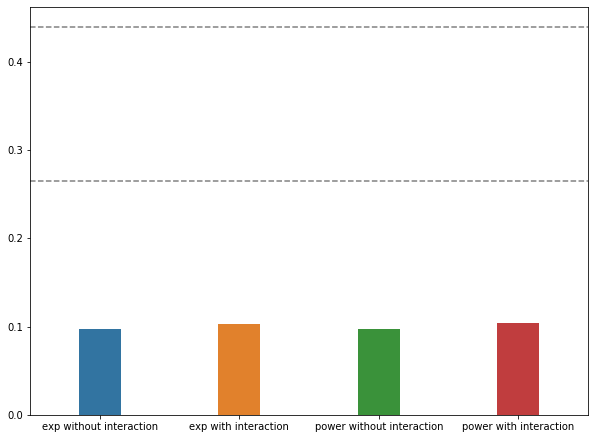

In [67]:
barplot_noisebounds(results_model_evaluat)

### Result from subject 1 region 2
### Number of voxels: 441

In [68]:
model_dict12=get_design_matrix(location12)
results_model_evaluat12=model_evaluation(y_res12, model_dict12)
results_model_evaluat12

{'exp without interaction': [0.21860361729757405, 0.22033130161246356],
 'exp with interaction': [0.23420279154933382, 0.23618363692975486],
 'power without interaction': [0.2188225654439243, 0.22055080366710636],
 'power with interaction': [0.23435086064542332, 0.23633210399347665],
 'noise ceiling': [0.4076327587423478, 0.548093556692324]}

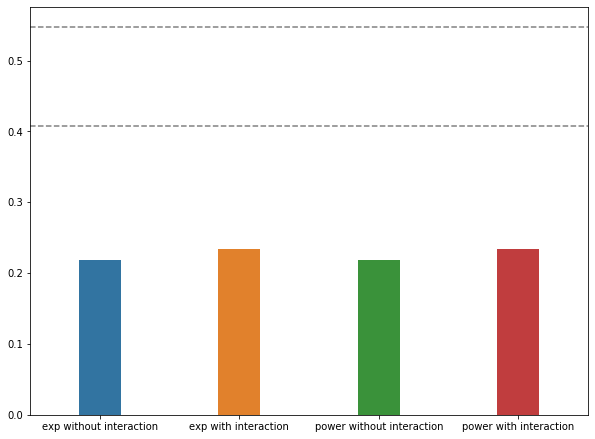

In [69]:
barplot_noisebounds(results_model_evaluat12)

### Result from subject 1 region 3
### Number of voxels: 1284

In [70]:
model_dict13=get_design_matrix(location13)
results_model_evaluat13=model_evaluation(y_res13, model_dict13)
results_model_evaluat13

{'exp without interaction': [0.09046037858606464, 0.09264374684788486],
 'exp with interaction': [0.09460793508827334, 0.09683836816885336],
 'power without interaction': [0.09060907342721927, 0.09278976747353918],
 'power with interaction': [0.09474343155480015, 0.09697113993577813],
 'noise ceiling': [0.16753058465308407, 0.36808647837898195]}

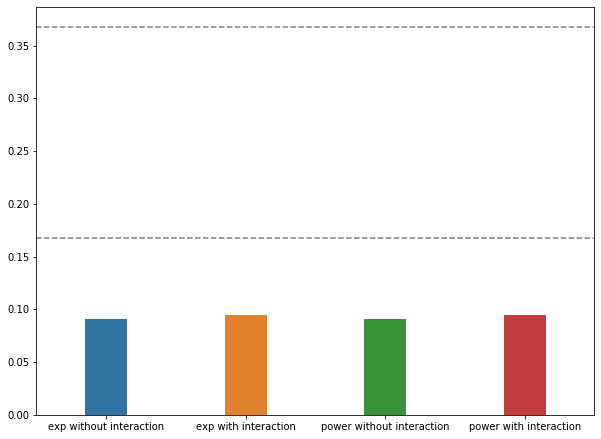

In [71]:
barplot_noisebounds(results_model_evaluat13)

### Result from subject 2 region 1
### Number of voxels:1021

In [72]:
model_dict21=get_design_matrix(location21)
results_model_evaluat21=model_evaluation(y_res21, model_dict21)
results_model_evaluat21

{'exp without interaction': [0.14844609334700243, 0.14919693806572776],
 'exp with interaction': [0.1508358693227292, 0.15159301059577998],
 'power without interaction': [0.1484836725010797, 0.1492343250899106],
 'power with interaction': [0.15086561146970268, 0.15162255172288613],
 'noise ceiling': [0.626308741108303, 0.71372765645245]}

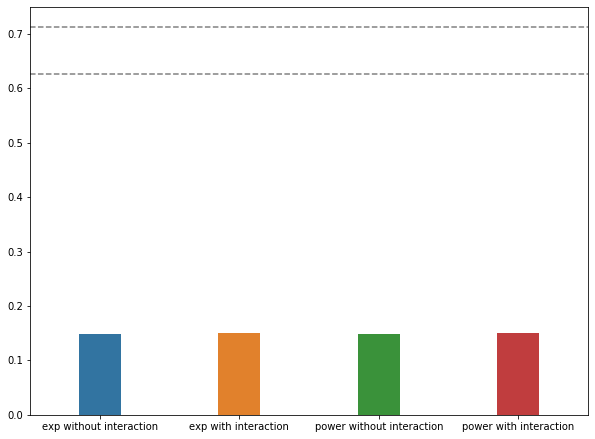

In [75]:
barplot_noisebounds(results_model_evaluat21)

### Result from subject 2 region 2
### Number of voxels:508

In [76]:
model_dict22=get_design_matrix(location22)
results_model_evaluat22=model_evaluation(y_res22, model_dict22)
results_model_evaluat22

{'exp without interaction': [0.27590521006671376, 0.27767298821637054],
 'exp with interaction': [0.2896286611755732, 0.2915283192868454],
 'power without interaction': [0.2761994893084641, 0.27796869180059414],
 'power with interaction': [0.2898544510191445, 0.29175506458797296],
 'noise ceiling': [0.6179259553003312, 0.7075792339220104]}

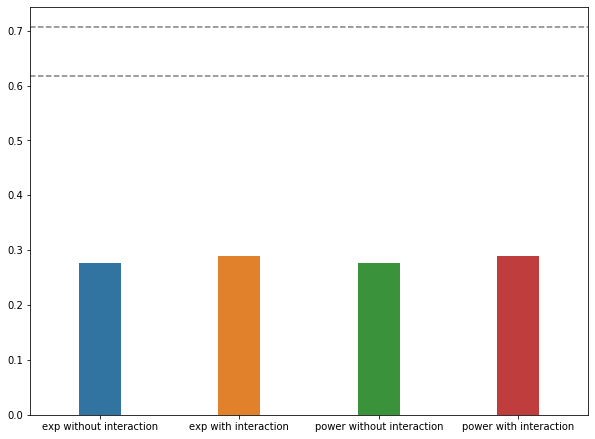

In [77]:
barplot_noisebounds(results_model_evaluat22)

### Result from subject 2 region 3
### NUmber of voxels: 1279

In [78]:
model_dict23=get_design_matrix(location23)
results_model_evaluat23=model_evaluation(y_res23, model_dict23)
results_model_evaluat23

{'exp without interaction': [0.09043080275894183, 0.09083742613785253],
 'exp with interaction': [0.09561112931245935, 0.09604045626401142],
 'power without interaction': [0.09064110737715603, 0.09104861734369922],
 'power with interaction': [0.09580852202475684, 0.09623867524190129],
 'noise ceiling': [0.39555872127630987, 0.5366599467945685]}

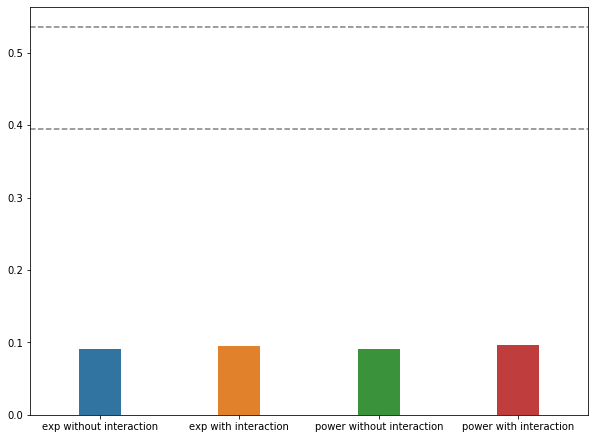

In [79]:
barplot_noisebounds(results_model_evaluat23)

### Subject 3 region 1
### Number of voxels:847

In [80]:
y_res31 = pd.read_csv('y_res31.csv', header=None)
col_names=['x', 'y', 'z', 'depth']
location31=pd.read_csv('location31.csv',names=col_names)

In [81]:
model_dict31=get_design_matrix(location31)
results_model_evaluat31=model_evaluation(y_res31, model_dict31)
results_model_evaluat31

{'exp without interaction': [0.09760114442580003, 0.10070287445147764],
 'exp with interaction': [0.10331725143637012, 0.10656827753648317],
 'power without interaction': [0.09769877969806812, 0.10079533388755355],
 'power with interaction': [0.10341400841356446, 0.10665994712201002],
 'noise ceiling': [0.2645672440387965, 0.43976879954419634]}

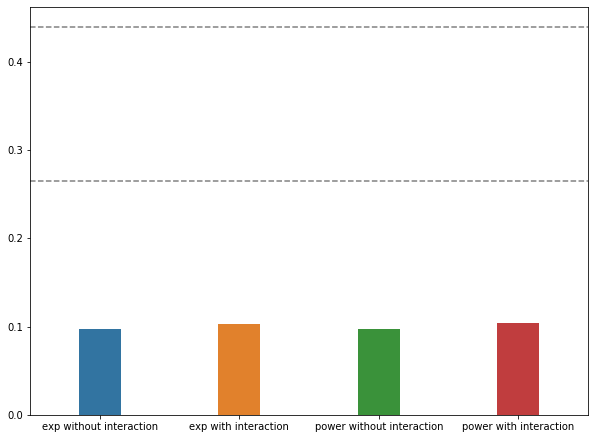

In [82]:
barplot_noisebounds(results_model_evaluat31)

### Subject 3 region 2
### Number of voxels: 426

In [83]:
y_res32 = pd.read_csv('y_res32.csv', header=None)
col_names=['x', 'y', 'z', 'depth']
location32=pd.read_csv('location32.csv',names=col_names)

In [84]:
model_dict32=get_design_matrix(location32)
results_model_evaluat32=model_evaluation(y_res32, model_dict32)
results_model_evaluat32

{'exp without interaction': [0.08802919725615461, 0.09002994425704997],
 'exp with interaction': [0.09528962982406011, 0.09735103809154444],
 'power without interaction': [0.08844771852474972, 0.09044643422117934],
 'power with interaction': [0.09564579391075684, 0.09770495731904637],
 'noise ceiling': [0.2884167896577382, 0.4578740210319515]}

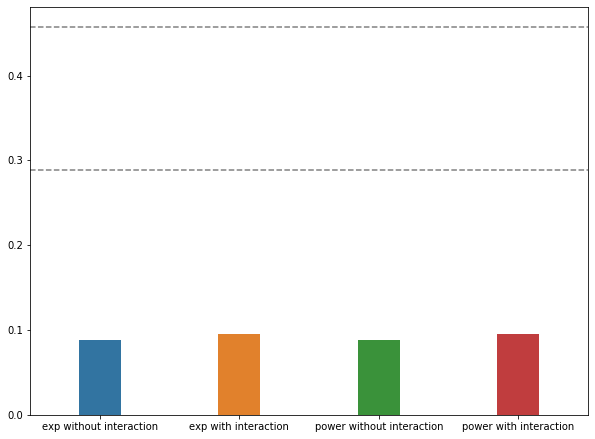

In [85]:
barplot_noisebounds(results_model_evaluat32)

### Subject 3 region 3
### Number of voxels: 1115

In [86]:
y_res33 = pd.read_csv('y_res33.csv', header=None)
col_names=['x', 'y', 'z', 'depth']
location33=pd.read_csv('location33.csv',names=col_names)

In [87]:
model_dict33=get_design_matrix(location33)
results_model_evaluat33=model_evaluation(y_res33, model_dict33)
results_model_evaluat33

{'exp without interaction': [0.04507124496023962, 0.04636757404055335],
 'exp with interaction': [0.04750489914553997, 0.04887810570759939],
 'power without interaction': [0.0452163153644726, 0.0465134919434666],
 'power with interaction': [0.047644841153144046, 0.04901887141109676],
 'noise ceiling': [0.11213510822862717, 0.3230492589573248]}

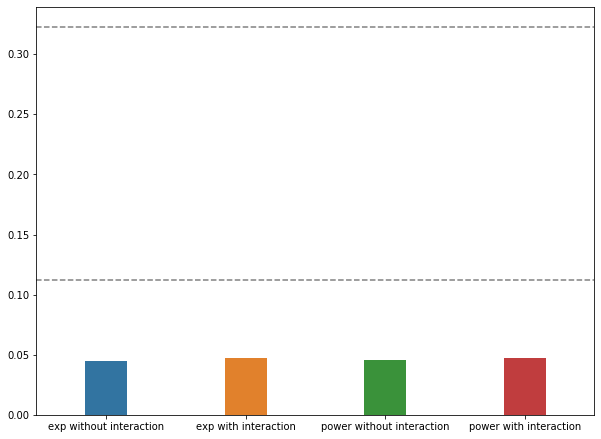

In [88]:
barplot_noisebounds(results_model_evaluat33)